# Notebook Instructions
<i>You can run the notebook document sequentially (one cell at a time) by pressing <b> shift + enter</b>. While a cell is running, a [*] will display on the left. When it has been run, a number will display indicating the order in which it was run in the notebook [8].</i>

<i>Enter edit mode by pressing <b>`Enter`</b> or using the mouse to click on a cell's editor area. Edit mode is indicated by a green cell border and a prompt showing in the editor area.</i>

# Regression Tree

A regression tree automatically selects important predictors and suggests trading rules. In this notebook, we will learn to create a regression tree using Apple Inc. stock. The predictor variables are one-day returns, five-day returns, five-day standard deviation and so on. The target variable is one-day future return. The tree we create will help us create trading rules for when the future return is expected to be positive or negative.
<BR>

<B>Create a regression tree</B>
1. Import the data
1. Define predictor variables and a target variable
2. Split the data into train and test dataset
3. Create a regression tree model using the train data
4. Visualize the model

<B>Analyzing the performance</B><BR><BR>
Part I: Single leaf
1. Trading rule based on one leaf node with the highest expected value of a target variable
5. Compute performance in the train and test dataset

Part II: Full tree
1. Trading rule based on all the leaf node
5. Compute the performance in the train and test dataset

### Import the data

In [35]:
import pandas as pd
import quandl
from datetime import date

In [74]:
quandl.connection.ApiConfig.api_key= "_N85bWLCNCWz14smKHSi"

In [75]:
start = date(2008,1,1)
end= date.today()

In [76]:
data = quandl.get('WIKI/AAPL',start_date=start,end_date=end)
#data = pd.read_csv('AAPL.csv', index_col=0)
data.index = pd.to_datetime(data.index)
data.head(3)

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2008-01-02,199.27,200.26,192.55,194.84,38542100.0,0.0,1.0,25.608972,25.736201,24.745359,25.039656,269794700.0
2008-01-03,195.41,197.39,192.69,194.93,30073800.0,0.0,1.0,25.112909,25.367366,24.763351,25.051222,210516600.0
2008-01-04,191.45,193.00,178.89,180.05,51994000.0,0.0,1.0,24.603993,24.803190,22.989858,23.138934,363958000.0


### Define predictor variables and a target variable

We define a list of predictors from which the model will pick the best predictors. ret1 is the one-day returns, std5 is the five-day standard deviation and so on. <BR>

<font color='blue'>pct_change()</font> computes the percentage change from the immediately previous row by default and <font color='blue'>rolling_sum(window=n)</font> computes the sum of previous n rows. 

In [77]:
data.describe()

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
count,2575.000000,2575.000000,2575.000000,2575.000000,2.575000e+03,2575.000000,2575.00000,2575.000000,2575.000000,2575.000000,2575.000000,2.575000e+03
mean,261.045268,263.580311,258.188734,260.939203,2.865983e+07,0.011833,1.00233,72.992806,73.641394,72.295007,72.983598,1.095620e+08
std,172.243723,173.607610,170.568580,172.096825,1.857743e+07,0.167919,0.11824,44.230053,44.520595,43.938896,44.236221,8.963608e+07
min,79.450000,82.000000,78.200000,78.200000,5.624800e+06,0.000000,1.00000,10.210432,10.538143,10.049790,10.049790,1.147592e+07
25%,118.260000,119.365000,117.190000,118.640000,1.537580e+07,0.000000,1.00000,33.389849,33.750330,32.943263,33.351295,4.456616e+07
50%,174.350000,175.650000,172.000000,174.250000,2.361796e+07,0.000000,1.00000,69.118372,69.765704,68.376664,69.149468,8.639330e+07
75%,397.000000,400.310000,391.755000,396.477500,3.653150e+07,0.000000,1.00000,106.243914,107.269976,105.268516,106.241824,1.443774e+08
max,702.410000,705.070000,699.570000,702.100000,1.895606e+08,3.290000,7.00000,182.590000,183.500000,180.210000,181.720000,8.432424e+08


In [79]:
# Returns
data['ret1'] = data['Adj. Close'].pct_change()

data['ret5'] = pd.Series.rolling(data.ret1,center=False,window=5).sum()
data['ret10'] = pd.Series.rolling(data.ret1,center=False,window=10).sum()
data['ret20'] = pd.Series.rolling(data.ret1,center=False,window=20).sum()
data['ret40'] = pd.Series.rolling(data.ret1,center=False,window=40).sum()

# Standard Deviation
data['std5'] = pd.Series.rolling(data.ret1,center=False,window=5).std()
data['std10'] = pd.Series.rolling(data.ret1,center=False,window=10).std()
data['std20'] = pd.Series.rolling(data.ret1,center=False,window=20).std()
data['std40'] = pd.Series.rolling(data.ret1,center=False,window=40).std()

We define the target variable which is the future one-day returns of the Apple Inc. stock. <BR>
<font color='blue'>shift(periods=n)</font> shifts the values by n period(s). If the value of n is negative then, it shifts the values backward and vice-versa.

In [80]:
data['retFut1'] = data.ret1.shift(-1)

We drop the NaN values and store the predictor variables in X and target variable in y.

In [81]:
data = data.dropna()
predictor_list = ['ret1','ret5', 'ret10', 'ret20', 'ret40', 'std5', 'std10', 'std20', 'std40','Volume']
X = data[predictor_list]
y = data.retFut1

### Split the data into train and test dataset
This step is required to verify if the regression tree model we created is any good. We will split the dataset into two parts, first 80% of the dataset will use to create the model and the remaining 20% will be used as a test dataset.

In [82]:
train_length = int(len(data)*0.80)

X_train = X[:train_length] 
X_test =  X[train_length:]
y_train = y[:train_length]
y_test = y[train_length:]                   

We have training data in the X_train and y_train for creating the regression tree model and a X_test and y_test to verify the model on unseen data.

### Create regression tree model

We have used DecisionTreeRegressor from sklearn.tree to create the regression tree model. We choose to set min_samples_leaf to 400, but you are free to experiment with other values and see what is optimal on the train dataset. Generally, a leaf size should not be too small to avoid overfitting in the train dataset.

In [83]:
# Regression tree model
from sklearn.tree import DecisionTreeRegressor
dtr = DecisionTreeRegressor(min_samples_leaf = 400)

We create the regression tree model using fit() method on the train dataset.

In [84]:
dtr.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=400,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [85]:
# Uncomment below line to see details of DecisionTreeRegressor
# help(DecisionTreeRegressor)

### Visualize the model

We now visualize the regression tree created in the below step using the graphviz and sklearn's tree package.

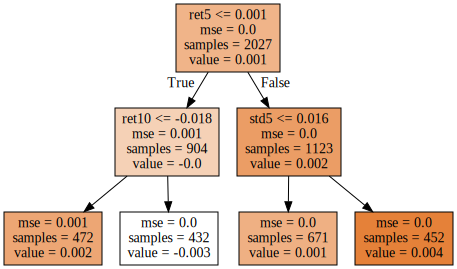

In [86]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Users/academy/Documents/graphviz-2.38/release/bin/'
#os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/release/bin/'
from sklearn import tree
import graphviz
dot_data = tree.export_graphviz(dtr, 
                                out_file=None, 
                                filled=True,   
                                feature_names=predictor_list)  
graphviz.Source(dot_data)  

To practice, create a regression tree model with min_samples_leaf as 100, 500 and 1000 and plot the tree to visualize the difference.

### Trading rule based on the leaf node with the highest target variable value

As seen from the above tree, the right-most child node has the highest value of 0.0037, which can be used to define a long rule. The rule can be paraphrased as when ret5 > 0.0014 (0.14%) and std5 > 0.0157 (0.157%) then buy, else do not buy. So predicted_signal is '1' when buy and '0' otherwise. 

j:\Anaconda3\envs\quantum\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


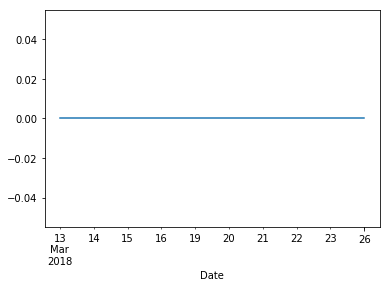

In [87]:
import numpy as np
#data['predicted_signal'] = np.where(((data.ret5 > 0.0014) & (data.std5 > 0.0155)), 1, 0)
data['predicted_signal'] = np.where(((data.ret5 > 0.001) & (data.std5 > 0.016)), 1, 0)
%matplotlib inline
# Visualizing the signal predicted for last 10 days
import matplotlib.pyplot as plt
import seaborn
data.predicted_signal[-10:].plot()
plt.show()

The above graph shows the signal predicted for last 10 days. The strategy returns are generated by multiplying the future returns by the predicted signal and stored in the strategy_returns.

In [88]:
data['strategy_returns_single_leaf'] = data.retFut1 * data.predicted_signal

j:\Anaconda3\envs\quantum\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


### Trading rule based on the full tree

We define a trading rule based on the expected response of every single leaf. If the expected value is positive then we buy the Apple Inc. stock and otherwise, we sell the stock.

In [89]:
data['predicted_signal'] = np.where(dtr.predict(X) > 0, 1,-1)
data['strategy_returns_full_tree'] = data.retFut1 * data.predicted_signal

j:\Anaconda3\envs\quantum\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
j:\Anaconda3\envs\quantum\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


### Performance computation for single leaf

Sharpe Ratio

The Sharpe ratio is calculated as follows:

<img src="https://d2a032ejo53cab.cloudfront.net/Glossary/R2TAJa6K/Sharpe-1.jpg"></img>

Where
- N is the number of trading days in a year
- Rf is the risk-free rate
- Std dev is the standard deviation

Sharpe ratio represents how good the strategy performance is for the risk (standard deviation) taken to achieve it. The higher the Sharpe ratio the better is the strategy. Generally, a Sharpe ratio of greater than 1.5 is preferred.

In [90]:
# The below function returns the Sharpe ratio for the excess returns (Strategy returns - Risk free rate) passed to it.
def annualized_sharpe_ratio(returns, N=252):
    return np.sqrt(N) * returns.mean() / returns.std()

We calculate the Sharpe ratio for the strategy in train and test dataset. The risk-free rate is assumed to be 5% p.a.

In [91]:
# Sharpe ratio
# Train dataset
data['excess_daily_strategy_return'] = data.strategy_returns_single_leaf - 0.05/252
sharpe_train_single_leaf = annualized_sharpe_ratio(data.excess_daily_strategy_return.iloc[:train_length])
# Test dataset
sharpe_test_single_leaf = annualized_sharpe_ratio(data.excess_daily_strategy_return.iloc[train_length:])

j:\Anaconda3\envs\quantum\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


### Strategy CAGR
CAGR represents the compounded annual returns of the strategy. The strategy CAGR is computed as follows:

<i>(Cumulative returns + 1)^(252/number of days) - 1</i>

where cumulative returns are the total strategy returns and number of days represent the total trading days.

In [92]:
def CAGR(returns):
    cumulative_returns = returns.cumsum().iloc[-1]   
    period_in_days = len(returns)
    return 100*((cumulative_returns+1)**(252.0/period_in_days)-1)

In [93]:
# Single Leaf
# Train dataset
ret_train_single_leaf = CAGR(data.strategy_returns_single_leaf.iloc[:train_length])
# Test dataset
ret_test_single_leaf = CAGR(data.strategy_returns_single_leaf.iloc[train_length:])

### Performance computation for full tree

In [94]:
# Full Tree

# Sharpe ratio
# Train dataset
data['excess_daily_strategy_return'] = data.strategy_returns_full_tree - 0.05/252
sharpe_train_full_tree = annualized_sharpe_ratio(data.excess_daily_strategy_return.iloc[:train_length])
# Test dataset
sharpe_test_full_tree = annualized_sharpe_ratio(data.excess_daily_strategy_return.iloc[train_length:])

# CAGR
# Train dataset
ret_train_full_tree = CAGR(data.strategy_returns_full_tree.iloc[:train_length])
# Test dataset
ret_test_full_tree = CAGR(data.strategy_returns_full_tree.iloc[train_length:])


j:\Anaconda3\envs\quantum\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


### Performance Comparision of single leaf and full tree

Cumulative returns in train dataset.

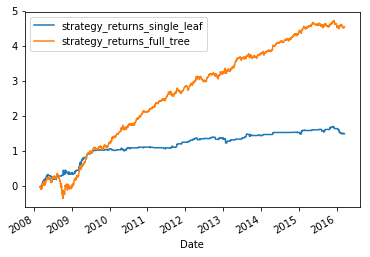

In [95]:
# Plot the cumulative returns for single leaf in train dataset
data.strategy_returns_single_leaf[:train_length].cumsum().plot()

# Plot the cumulative returns for full tree in train dataset
data.strategy_returns_full_tree[:train_length].cumsum().plot()

# Show the legend
plt.legend()

# Show the graph
plt.show()

Cumulative returns in the test dataset.

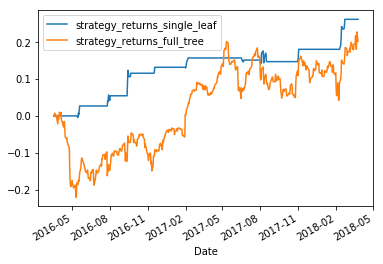

In [96]:
# Plot the cumulative returns for single leaf in train dataset
data.strategy_returns_single_leaf[train_length:].cumsum().plot()

# Plot the cumulative returns for full tree in train dataset
data.strategy_returns_full_tree[train_length:].cumsum().plot()

# Show the legend
plt.legend()

# Show the graph
plt.show()

In [97]:
from tabulate import tabulate

# Tabulate the performance in train and test dataset for single leaf and full tree
print(tabulate(
        [             
            ['CAGR', ret_train_single_leaf, ret_train_full_tree, ret_test_single_leaf, ret_test_full_tree],
            ['Sharpe Ratio', sharpe_train_single_leaf, sharpe_train_full_tree, sharpe_test_single_leaf, sharpe_test_full_tree],
        ], 
        headers=['Train (Single Leaf)', 'Train (Full Tree)', 'Test (Single Leaf)',  'Test (Full Tree)'], 
    tablefmt='orgtbl'))

|              |   Train (Single Leaf) |   Train (Full Tree) |   Test (Single Leaf) |   Test (Full Tree) |
|--------------+-----------------------+---------------------+----------------------+--------------------|
| CAGR         |             12.0472   |            23.7475  |             12.2777  |           9.59977  |
| Sharpe Ratio |              0.820545 |             1.58973 |              1.16452 |           0.251062 |


 In the next section, we will explore some ensemble techniques for reducing overfitting so that we can, in fact, use all leaves for prediction.
<BR>